In [3]:
!pip install -r requirements.txt
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.3/782.3 kB 71.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-3.0.12-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 81.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 51.0 MB/s eta 0:00:0

In [6]:
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import random
import time
import warnings
import zipfile
from tqdm import tqdm
import json
import s3fs
import io

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parquet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertTokenizer
from unidecode import unidecode


from src.features.functions_preprocessing import (
    plot_text_length_distribution,
    preprocess_articles,
    preprocess_summaries,
)
from src.features.tokenization import parallel_tokenize
from src.models.bert import BertSummary
from src.models.rnn_encoder_decoder import Encoder, Decoder, Seq2Seq
from src.models.transformer import Transformer
from src.models.train_models import train_model
from src.evaluation.model_evaluation import (
    generate_summaries_seq2seq,
    generate_summaries_transformer,
    generate_summaries_bert,
)

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [8]:
def get_allowed_cpu_count():
    # Returns the number of CPU cores available for this process.
    try:
        return len(os.sched_getaffinity(0))
    except AttributeError:
        return os.cpu_count() or 1


cpu_count = get_allowed_cpu_count()
print(cpu_count)

72


In [9]:
n_process = max(1, cpu_count // 2)

In [10]:
torch.set_num_threads(n_process)

# **Import Dataset from S3**

Download and extract the news summarization dataset from S3, then load it into a pandas DataFrame.

In [ ]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

MY_BUCKET = config['MY_BUCKET']
CHEMIN_FICHIER = config['CHEMIN_FICHIER']

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

with fs.open(f"s3://{MY_BUCKET}/{CHEMIN_FICHIER}") as f:
    # Lire le contenu du fichier ZIP dans la mémoire
    zip_content = io.BytesIO(f.read())

with zipfile.ZipFile(zip_content, "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [11]:
news_data = pd.read_csv("news-summarization/data.csv")

We pick a random article from the dataset and display both its content and the corresponding summary to compare.

In [12]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

The late Casey Kasem's lavish Beverly Hills mansion has been put up for sale by his widow Jean at a price of $42 million. The legendary broadcaster died on Sunday, aged 82, after a long battle with dementia and Parkinson's disease amid a bitter family feud over his medical care. Kasem's second wife Jean has placed the 12,000 square-foot property, which comes with a piece of the Brooklyn Bridge, a par-three golf course and a heart shaped pool up for grabs at a hefty price of $42 million. Scroll down for video . The property is located in Beverly Hills, California, where its new owner will become a neighbour to such stars as Charlie Sheen, Taylor Swift and Sharon Stone . The property includes a swimming pool to cool off in after a few rounds of tennis and can accommodate plenty of people using its eight bedrooms and 14 bathrooms . The . American DJ was best known for his voice acting of the cartoon character . Shaggy from the Scooby-Doo franchise and hosting the radio show . 'American To

We filter out very short and very long articles (outside the 10th and 90th percentiles) and then plot the length distribution of the remaining articles.

In [13]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [14]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.10))
    & (lengths_article <= lengths_article.quantile(0.90))
]

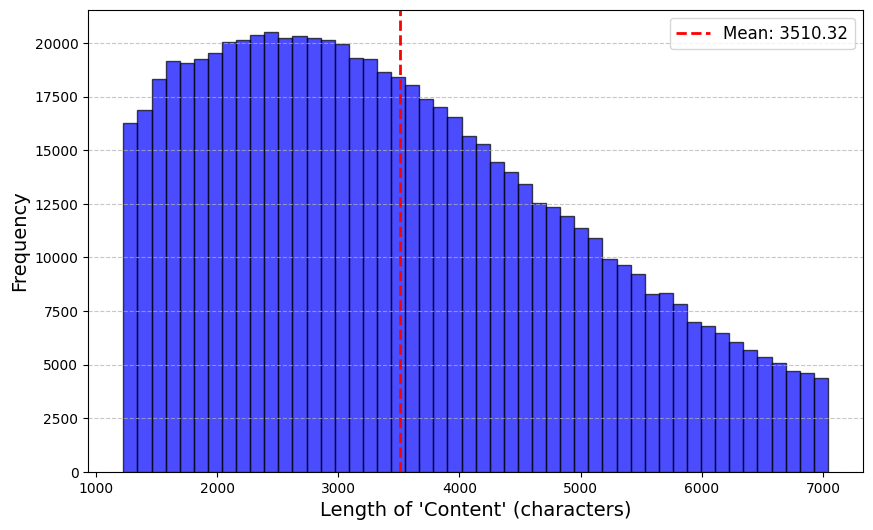

In [15]:
plot_text_length_distribution(news_data, "Content")

We do the same for summaries.

In [16]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    696451.000000
mean        283.484382
std         208.280906
min           1.000000
25%         163.000000
50%         247.000000
75%         326.000000
max        8541.000000
Name: Summary, dtype: float64

In [17]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.10))
    & (lengths_summary <= lengths_summary.quantile(0.90))
]

In [18]:
news_data["Summary"].str.len().describe()

count    558032.00000
mean        250.39556
std          78.90248
min         120.00000
25%         189.00000
50%         247.00000
75%         307.00000
max         435.00000
Name: Summary, dtype: float64

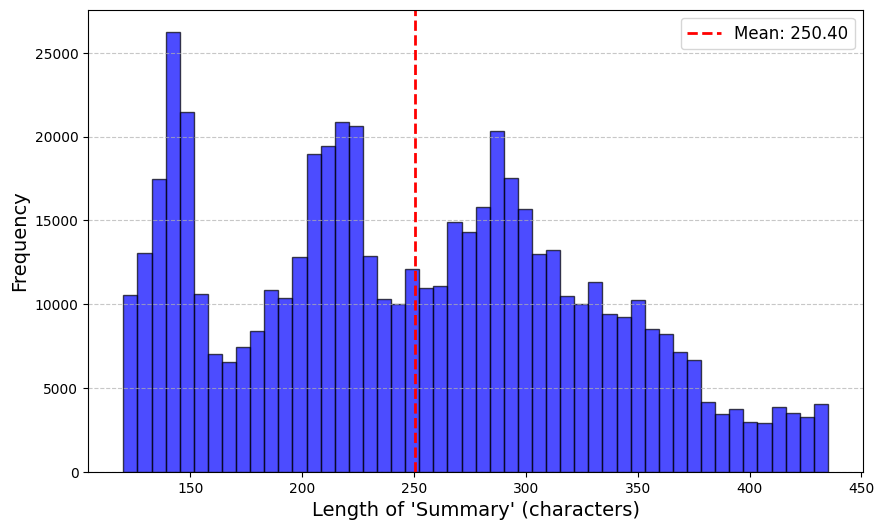

In [19]:
plot_text_length_distribution(news_data, "Summary")

In [20]:
len(news_data)

558032

We preprocess the articles and summaries using parallel processing to clean and standardize the text data efficiently.

In [ ]:
news_data.loc[:, "Content"] = preprocess_articles(
    news_data["Content"].tolist(), n_process=n_process, batch_size=32
)
news_data.loc[:, "Summary"] = preprocess_summaries(
    news_data["Summary"].tolist(), n_process=n_process, batch_size=32
)

In [ ]:
news_data.to_parquet("news_data_cleaned.parquet", index=False)

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

s3_parquet_path = f"s3://{MY_BUCKET}/data/news_data_cleaned.parquet"

with open(news_data_cleaned.parquet, 'rb') as f:
    fs.put(s3_parquet_path, f)

print(f"Fichier envoyé avec succès à {s3_parquet_path}")

In [ ]:
news_data = pd.read_parquet("news_data_cleaned.parquet")

# **Tokenization**

In [ ]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)

MY_BUCKET = config['MY_BUCKET']

s3_parquet_path = f"s3://{MY_BUCKET}/data/news_data_cleaned.parquet"

# Initialiser le système de fichiers S3
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

# Lire le fichier Parquet depuis le bucket S3
with fs.open(s3_parquet_path, 'rb') as f:
    news_data = pd.read_parquet(f)


We shuffle the dataset, split it into training and testing sets with an 80-20 ratio, and print the sizes of both subsets.

In [ ]:
data_copy = news_data[:]
data_copy = news_data.sample(frac=1, random_state=42)

train_ratio = 0.8
train_size = int(train_ratio * len(data_copy))

# Slice the dataset
train_data = data_copy[:train_size]
test_data = data_copy[train_size:]

print(f"Train size: {len(train_data)}")
print(f"Test size:  {len(test_data)}")

We tokenize the content of the articles & summaries in parallel using a BERT tokenizer, then save the tokenized result as a PyTorch tensor.

In [ ]:
if __name__ == "__main__":
    texts_content = list(train_data["Content"])
    print("Tokenizing Content...")
    tokenized_articles = parallel_tokenize(
        texts_content,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=512,
    )
    print("tokenized_articles.shape =", tokenized_articles.shape)
    torch.save(tokenized_articles, "tokenized_articles.pt")

In [ ]:
if __name__ == "__main__":
    texts_summary = list(train_data["Summary"])
    print("Tokenizing Summaries...")
    tokenized_summaries = parallel_tokenize(
        texts_summary,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=129,
    )
    print("tokenized_summaries.shape =", tokenized_summaries.shape)
    torch.save(tokenized_summaries, "tokenized_summaries.pt")

In [ ]:
if __name__ == "__main__":
    texts_content = list(test_data["Content"])
    print("Tokenizing Content...")
    tokenized_articles_test = parallel_tokenize(
        texts_content,
        tokenizer_name="bert-base-uncased",
        max_workers=n_process,
        chunk_size=2000,
        max_length=512,
    )
    print("tokenized_articles.shape =", tokenized_articles_test.shape)
    torch.save(tokenized_articles_test, "tokenized_articles_test.pt")

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tokenized_articles = torch.load("tokenized_articles.pt")
    tokenized_summaries = torch.load("tokenized_summaries.pt")
    tokenized_articles_test = torch.load("tokenized_articles_test.pt")

In [ ]:
article_ids = tokenized_articles.long()
summary_ids = tokenized_summaries.long()

# **Seq2Seq**

We create a dataset and dataloader for training, then initialize an encoder and decoder, and finally the Seq2Seq model.

In [ ]:
batch_size = 32

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers=n_process, shuffle=True
)

In [ ]:
encoder = Encoder(
    vocab_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    embed_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout_prob=0.1,
)
decoder = Decoder(
    vocab_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    embed_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout_prob=0.1,
)

modelSeq2Seq = Seq2Seq(encoder, decoder, device).to(device)

We train the Seq2Seq model for 30 epochs using the Adam optimizer and cross-entropy loss.

In [ ]:
train_model(
    model=modelSeq2Seq,
    dataloader=dataloader,
    num_epochs=25,
    optimizer=torch.optim.Adam(modelSeq2Seq.parameters(), lr=2e-4),
    loss_fn=nn.CrossEntropyLoss(
        ignore_index=BertTokenizer.from_pretrained("bert-base-uncased").pad_token_id
    ),
    model_name="Seq2Seq",
    device=device,
    teacher_forcing_ratio=0.5,
)

We initialize the encoder, decoder, and Seq2Seq model, load pre-trained weights from a previous run (after 25 epochs), and set the model to evaluation mode.

In [ ]:
encoder = Encoder(
    vocab_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    embed_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout_prob=0.1,
)
decoder = Decoder(
    vocab_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    embed_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout_prob=0.1,
)

modelSeq2Seq = Seq2Seq(encoder, decoder, device).to(device)

modelSeq2Seq.load_state_dict(torch.load("model_weights/seq2seq_weights_25_epochs.pth"))
modelSeq2Seq.eval()

# **Transformer**

We create a dataset and dataloader, then initialize a Transformer model with BERT's vocabulary size, hidden size, 8 attention heads, and 3 layers.

In [ ]:
batch_size = 32

dataset = TensorDataset(tokenized_articles, tokenized_summaries)
dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers=n_process, shuffle=True
)

In [ ]:
modelTransformer = Transformer(
    pad_idx=0,
    voc_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=512,
    ffn_hidden=128,
    n_layers=3,
)

We train the Transformer model for 25 epochs using the Adam optimizer and cross-entropy loss.

In [ ]:
train_model(
    model=modelTransformer,
    dataloader=dataloader,
    num_epochs=25,
    optimizer=torch.optim.Adam(modelTransformer.parameters(), lr=2e-4),
    loss_fn=nn.CrossEntropyLoss(
        ignore_index=BertTokenizer.from_pretrained("bert-base-uncased").pad_token_id
    ),
    model_name="Transformer",
    device=device,
)

We initialize the Transformer model, load the pre-trained weights from a previous run (after 25 epochs), and set the model to evaluation mode.

In [ ]:
modelTransformer = Transformer(
    pad_idx=0,
    voc_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=512,
    dec_max_len=128,
    ffn_hidden=128,
    n_layers=3,
)
modelTransformer.load_state_dict(
    torch.load("model_weights/transformer_weights_25_epochs.pth")
)
modelTransformer.eval()

# **BERT model**

We create a dataset and dataloader with smaller batch size, then configure a BERT model with 12 hidden layers, 12 attention heads, and standard BERT parameters, and finally initialize the BertSummary model.

In [ ]:
batch_size = 8

dataset = TensorDataset(tokenized_articles, tokenized_summaries_bert[:, 1:])
dataloader = DataLoader(
    dataset, batch_size=batch_size, num_workers=n_process, shuffle=True
)

In [ ]:
config = BertConfig(
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    vocab_size=BertTokenizer.from_pretrained("bert-base-uncased").vocab_size,
)

In [ ]:
modelBert = BertSummary(config)

We train the BERT-based summarization model for 7 epochs using the Adam optimizer and cross-entropy loss.

In [ ]:
train_model(
    model=modelBert,
    dataloader=dataloader,
    num_epochs=7,
    optimizer=torch.optim.Adam(modelBert.parameters(), lr=1e-5),
    loss_fn=nn.CrossEntropyLoss(
        ignore_index=BertTokenizer.from_pretrained("bert-base-uncased").pad_token_id
    ),
    model_name="BERT",
    device=device,
)

We initialize the BERT summarization model, load pre-trained weights from a previous run (after 7 epochs) and set it to evaluation mode.

In [ ]:
modelBert = BertSummary(config)
modelBert.load_state_dict(torch.load("model_weights/bert_weights_7_epochs.pth"))
modelBert.to(device)
modelBert.eval()

# **Evaluation**

We load the ROUGE evaluation metric, which is commonly used to assess the quality of generated text summaries by comparing them to reference summaries.

In [ ]:
rouge = evaluate.load("rouge")

## Seq2Seq

We generate summaries using the Seq2Seq model.

In [ ]:
predictions_seq2seq = generate_summaries_seq2seq(
    model=modelSeq2Seq,
    batch_size=32,
    tokenized_input=tokenized_articles_test,
    limit=None,
)

In [ ]:
test_data.loc[:, "predictions_seq2seq"] = predictions_seq2seq

We compute ROUGE metrics by comparing the Seq2Seq model's generated summaries to the reference summaries from the test set.

In [ ]:
reference_summaries = list(test_data["Summary"])
results = rouge.compute(predictions=predictions_seq2seq, references=reference_summaries)
print("ROUGE metrics:", results)

## Transformer

We generate summaries using the Transformer model.

In [ ]:
predictions_transformer = generate_summaries_transformer(
    model=modelTransformer,
    batch_size=32,
    tokenized_input=tokenized_articles_test,
    limit=None,
)

In [ ]:
test_data.loc[:, "predictions_transformer"] = predictions_transformer

We compute ROUGE metrics by comparing the Transformer model's generated summaries to the reference summaries from the test set.

In [ ]:
reference_summaries = list(test_data["Summary"])
results = rouge.compute(
    predictions=predictions_transformer, references=reference_summaries
)
print("ROUGE metrics:", results)

## Bert

We generate summaries using the BERT model.

In [ ]:
predictions_bert = generate_summaries_bert(
    model=modelBert,
    batch_size=32,
    tokenized_input=tokenized_articles_test,
    limit=None,
)

In [ ]:
test_data.loc[:, "predictions_bert"] = predictions_bert

We compute ROUGE metrics by comparing the BERT model's generated summaries to the reference summaries from the test set.

In [ ]:
reference_summaries = list(test_data["Summary"])
results = rouge.compute(predictions=predictions_bert, references=reference_summaries)
print("ROUGE metrics:", results)